In [2]:
# 화면 넓게 보기
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# ⭐️ 버스 정류소 월별 승하차 인원 합계 및 정류소 위치 정보
- 목표: 월평균 유동인구가 많은 버스정류장의 위치 데이터
  - 1단계 : 데이터 전처리
    - 필요없는 컬럼 삭제
    - 병합을 위해 컬럼 이름 통일 및 데이터 타입 일치시키기
    - 해당 자료는 시간대별 승하차 인구를 모두 포함함
      - 시간대별 유동인 수가 필요한 것이 아니라 월평균 총유동인구 수가 필요하므로 정류장별 월평균유동인구 값을 구하기(승차, 하차 구분)
  - 2단계 : 정류소별 월, 시간대별 승하차 인원 수를 포함하는 데이터프레임과 버스 정류장의 위치 좌표를 가진 데이터프레임 병합

## ✅ 데이터 전처리

In [3]:
# 필요한 라이브러리
!pip install haversine
!pip install tqdm
!pip install folium

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from glob import glob
from tqdm import tqdm
from haversine import haversine
import geopy.distance
import numpy as np
import random
import folium
from folium.features import CustomIcon
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform

try:

    if platform.system() == 'Windows':

        #윈도우인 경우

        font_name = font_manager.FontProperties(fname="c:/Windows/fonts/malgun.ttf").get_name()

        rc('font', family=font_name)

    else:

        #Mac인 경우

        rc('font', family='AppleGothic')

except:

    pass

matplotlib.rcParams['axes.unicode_minus'] = False

In [6]:
# 1월 ~ 12월의 정류장별, 시간대별 승하차 승객 수 데이터 불러오기
file_list = glob('/Users/nabong/Desktop/project_login/data/busstop/*.csv')
df_origin = []
for f in file_list:
  df = pd.read_csv(f, encoding='cp949')
  df_origin.append(df)

# 버스정류소의 위치 데이터 불러오기
stop_loc = pd.read_excel('/Users/nabong/Desktop/project_login/data/busstop/busstop_location_seoul.xlsx')

/var/folders/5z/x3njjl9j3tb_1llqpqvxxqhm0000gn/T/ipykernel_49334/2921934671.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
/var/folders/5z/x3njjl9j3tb_1llqpqvxxqhm0000gn/T/ipykernel_49334/2921934671.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
/var/folders/5z/x3njjl9j3tb_1llqpqvxxqhm0000gn/T/ipykernel_49334/2921934671.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
/var/folders/5z/x3njjl9j3tb_1llqpqvxxqhm0000gn/T/ipykernel_49334/2921934671.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='cp949')
/var/folders/5z/x3njjl9j3tb_1llqpqvxxqhm0000gn/T/ipykernel_49334/2921934671.py:5: DtypeWarning: Columns (4) have

In [7]:
# 컬렴명 비교 결과
#   3,4,5,6월의 사용년월 컬럼이름이 다름 - 일치 시켜줄 것
#   8월부터 추가된 필요없는 추가 컬럼 제거 - '교통수단타입코드', '교통수단타입명', '등록일자'
for df in df_origin:
  print(df.columns)

Index(['사용년월', '노선번호', '노선명', '표준버스정류장ID', '버스정류장ARS번호', '역명', '00시승차총승객수',
       '00시하차총승객수', '1시승차총승객수', '1시하차총승객수', '2시승차총승객수', '2시하차총승객수', '3시승차총승객수',
       '3시하차총승객수', '4시승차총승객수', '4시하차총승객수', '5시승차총승객수', '5시하차총승객수', '6시승차총승객수',
       '6시하차총승객수', '7시승차총승객수', '7시하차총승객수', '8시승차총승객수', '8시하차총승객수', '9시승차총승객수',
       '9시하차총승객수', '10시승차총승객수', '10시하차총승객수', '11시승차총승객수', '11시하차총승객수',
       '12시승차총승객수', '12시하차총승객수', '13시승차총승객수', '13시하차총승객수', '14시승차총승객수',
       '14시하차총승객수', '15시승차총승객수', '15시하차총승객수', '16시승차총승객수', '16시하차총승객수',
       '17시승차총승객수', '17시하차총승객수', '18시승차총승객수', '18시하차총승객수', '19시승차총승객수',
       '19시하차총승객수', '20시승차총승객수', '20시하차총승객수', '21시승차총승객수', '21시하차총승객수',
       '22시승차총승객수', '22시하차총승객수', '23시승차총승객수', '23시하차총승객수', '교통수단타입코드',
       '교통수단타입명', '등록일자'],
      dtype='object')
Index(['?"사용년월"', '노선번호', '노선명', '표준버스정류장ID', '버스정류장ARS번호', '역명', '00시승차총승객수',
       '00시하차총승객수', '1시승차총승객수', '1시하차총승객수', '2시승차총승객수', '2시하차총승객수', '3시승차총승객수',
       '3시하차총승객수', '4시승차총승객수', '4시하차총승객수', '5시승차

In [8]:
# 버스정류장ARS번호 - 숫자형으로 추정되나 object 타입이라 내용확인필요
df_origin[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40378 entries, 0 to 40377
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   사용년월        40378 non-null  int64 
 1   노선번호        40378 non-null  object
 2   노선명         40378 non-null  object
 3   표준버스정류장ID   40378 non-null  int64 
 4   버스정류장ARS번호  40378 non-null  object
 5   역명          40378 non-null  object
 6   00시승차총승객수   40378 non-null  int64 
 7   00시하차총승객수   40378 non-null  int64 
 8   1시승차총승객수    40378 non-null  int64 
 9   1시하차총승객수    40378 non-null  int64 
 10  2시승차총승객수    40378 non-null  int64 
 11  2시하차총승객수    40378 non-null  int64 
 12  3시승차총승객수    40378 non-null  int64 
 13  3시하차총승객수    40378 non-null  int64 
 14  4시승차총승객수    40378 non-null  int64 
 15  4시하차총승객수    40378 non-null  int64 
 16  5시승차총승객수    40378 non-null  int64 
 17  5시하차총승객수    40378 non-null  int64 
 18  6시승차총승객수    40378 non-null  int64 
 19  6시하차총승객수    40378 non-null  int64 
 20  7시승차총승

In [9]:
# 컬럼명이 승하차 승객 자료와 일치하지 않으므로 추후에 변경
stop_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11226 entries, 0 to 11225
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NODE_ID  11226 non-null  int64  
 1   ARS-ID   11226 non-null  int64  
 2   정류소명     11226 non-null  object 
 3   X좌표      11226 non-null  float64
 4   Y좌표      11226 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 438.6+ KB


In [10]:
# 데이터 구조확인(1월) - 해당 데이터는 승차 승객수와 하차 승객수가 같이 있음
df_origin[0].head(2)

,사용년월,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,00시승차총승객수,00시하차총승객수,1시승차총승객수,1시하차총승객수,...,20시하차총승객수,21시승차총승객수,21시하차총승객수,22시승차총승객수,22시하차총승객수,23시승차총승객수,23시하차총승객수,교통수단타입코드,교통수단타입명,등록일자
0,202208,741,741번(진관차고지~헌인릉입구),100000001,1001,종로2가사거리(00077),118,82,82,91,...,184,292,172,257,146,192,102,10,서울간선버스,20220903
1,202208,N37,N37번(송파공영차고지~진관공영차고지),100000001,1001,종로2가사거리(00032),3,7,268,226,...,0,0,0,0,0,0,0,51,서울심야버스,20220903


In [9]:
# 정류장id로 정류장 수 확인
len(df_origin[0]['표준버스정류장ID'].unique())

12642

In [10]:
# object 타입이었던 ars번호의 값 확인 - '~' 값이 들어가있음
df_origin[0]['버스정류장ARS번호'].value_counts()

~        222
3005      34
3006      34
1044      29
1023      29
        ... 
19877      1
19885      1
19884      1
19868      1
16107      1
Name: 버스정류장ARS번호, Length: 12566, dtype: int64

In [11]:
# 승하차 데이터 전처리 함수
def data_cleaning(df_origin):
  df_cleaned = []
  for df in df_origin:
    # 필요없는 컬럼 드롭
    df.drop(labels=['노선명', '등록일자'], axis=1, inplace=True)
    
    if '교통수단타입코드' in df.columns:
      df.drop('교통수단타입코드', axis=1, inplace=True)
    
    if '교통수단타입명' in df.columns:
      df.drop('교통수단타입명', axis=1, inplace=True)
      
    # 컬럼명 통합
    if '?"사용년월"' in df.columns:
      df = df.rename(columns={'?"사용년월"':'사용년월', '표준버스정류장ID': 'node_id', '버스정류장ARS번호': 'ars_id', '역명':'정류소명(역명)', '정류소명':'정류소명(역명)'})
    else:
      df = df.rename(columns={'표준버스정류장ID': 'node_id', '버스정류장ARS번호': 'ars_id',  '역명':'정류소명(역명)', '정류소명':'정류소명(역명)'})
    
    # 사용년월 결측값 채우기(ffill)
    df['사용년월'] = df['사용년월'].fillna(method='ffill')
    
    # 변수 타입 변경
    df['사용년월'] = df['사용년월'].astype('str')
    # ARS_ID의 값중 '~'가 포함된 정류장은 실제 승하차가 이뤄지지 않는 위치 추적용 가상 정류장이므로 드롭 후 int로 형변환
    drop_index = (df[df['ars_id'] == '~']).index
    df = df.drop(drop_index, axis=0)
    df['ars_id'] = df['ars_id'].astype('int')

    # 승하차 총합계 컬럼 추가
    df['승차총합계'] = df.iloc[:, 5::2].apply(np.sum, axis=1)
    df['하차총합계'] = df.iloc[:, 6::2].apply(np.sum, axis=1)
    df['승하차총합계'] = df['승차총합계'] + df['하차총합계']

    df_cleaned.append(df)

  return df_cleaned

In [12]:
# 정류장 위치정보 데이터 전처리
# stop_loc의 컬럼명을 df_final의 컬럼명과 일치시키기 (node_id, ars_id, 역명)
stop_loc = stop_loc.rename(columns={'NODE_ID':'node_id', 'ARS-ID':'ars_id', '정류소명':'정류소명(역명)'})
# 정류소 고유 번호인 node_id가 존재하므로 ars_id 드롭
stop_loc = stop_loc.drop('ars_id', axis=1)

stop_loc.head(2)

,node_id,정류소명(역명),X좌표,Y좌표
0,100000001,종로2가사거리,126.987750,37.569765
1,100000002,창경궁.서울대학교병원,126.996566,37.579183


In [13]:
# 승하차 데이터 전처리
df_cleaned = data_cleaning(df_origin)
df_cleaned[0].head()

,사용년월,노선번호,node_id,ars_id,정류소명(역명),00시승차총승객수,00시하차총승객수,1시승차총승객수,1시하차총승객수,2시승차총승객수,...,20시하차총승객수,21시승차총승객수,21시하차총승객수,22시승차총승객수,22시하차총승객수,23시승차총승객수,23시하차총승객수,승차총합계,하차총합계,승하차총합계
0,202208,741,100000001,1001,종로2가사거리(00077),118,82,82,91,0,...,184,292,172,257,146,192,102,6103,6233,12336
1,202208,N37,100000001,1001,종로2가사거리(00032),3,7,268,226,105,...,0,0,0,0,0,0,0,376,349,725
2,202208,470,100000001,1001,종로2가사거리(00067),72,70,0,3,0,...,220,305,201,257,183,238,130,7458,6293,13751
3,202208,N37,100000001,1001,종로2가사거리(00089),0,0,0,0,67,...,0,0,0,0,0,0,0,414,306,720
4,202208,100,100000002,1002,창경궁.서울대학교병원(00031),0,0,0,0,0,...,31,54,24,41,48,34,2,3089,3805,6894


## ✅ 월평균 유동인구총합 구하기

In [22]:
# 월, 정류소별 승하차 총합계 데이터를 병합한 최종 테이블을 구하는 함수
def get_merge(df_cleaned):
  # 월, 정류소별 승하차 총합계
  for df in df_cleaned:
    df_sum = []
    sum = df.groupby('node_id')[['승차총합계', '하차총합계', '승하차총합계']].sum().reset_index()
    df_sum.append(sum)
  
  # 데이터 프레임 병합(1월~12월)
  # 월, 정류소별 월평균 승하차 수
  df_merged = pd.concat(df_sum, axis=0).groupby('node_id')[['승차총합계', '하차총합계', '승하차총합계']].mean().round(2)
  # node_id를 index -> column 변경, 데이터 타입을 string으로 변경
  df_merged = df_merged.reset_index()

  # 컬럼 이름 변경
  df_merged = df_merged.rename(columns={'승차총합계':'월평균승차수', '하차총합계':'월평균하차수', '승하차총합계':'월평균승하차총계'})
  return df_merged

In [23]:
df_merged = get_merge(df_cleaned)
df_merged.info()
df_merged

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12588 entries, 0 to 12587
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   node_id   12588 non-null  int64  
 1   월평균승차수    12588 non-null  float64
 2   월평균하차수    12588 non-null  float64
 3   월평균승하차총계  12588 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 393.5 KB


,node_id,월평균승차수,월평균하차수,월평균승하차총계
0,100000001,14645.0,13676.0,28321.0
1,100000002,81002.0,70081.0,151083.0
2,100000003,134621.0,92019.0,226640.0
3,100000004,19992.0,23697.0,43689.0
4,100000005,50309.0,77328.0,127637.0
...,...,...,...,...
12583,277103814,0.0,1.0,1.0
12584,277104249,1.0,48.0,49.0
12585,277104250,0.0,196.0,196.0
12586,277104251,1.0,138.0,139.0


In [18]:
# # get_merge의 병합과정이 잘 진행됐는지 확인
# # 랜덤 추출한 정류장의 월평균 승차수 값 비교
# # 테스트 데이터 : 각 월별로 정류소 id=random인 데이터만 뽑아 concat으로 모두 합치기
# y = pd.DataFrame()
# random = df_merged.sample(1)['node_id'].iloc[0]
# for df in df_cleaned:
#   x = df[df['node_id'] == random][['node_id', '승차총합계', '하차총합계']]
#   y = pd.concat([y, x], axis=0)

# # 테스트 평균
# mean_test = round(y['승차총합계'].sum()/12, 2)
# # 함수 결과 평균
# mean_func = df_merged[df_merged['node_id'] == random]['월평균승차수']
# # 결과
# print('평균 비교 결과: ', mean_test == mean_func)

## ✅ 위치정보 데이터와 합치기

In [15]:
stop_loc

,node_id,정류소명(역명),X좌표,Y좌표
0,100000001,종로2가사거리,126.987750,37.569765
1,100000002,창경궁.서울대학교병원,126.996566,37.579183
2,100000003,명륜3가.성대입구,126.998340,37.582671
3,100000004,종로2가.삼일교,126.987613,37.568579
4,100000005,혜화동로터리.여운형활동터,127.001744,37.586243
...,...,...,...,...
11221,124000334,우성아파트,127.139339,37.550386
11222,124000333,우성아파트,127.140046,37.550643
11223,124000332,조일약국,127.123596,37.533630
11224,124000331,성내시장,127.125497,37.536155


In [27]:
df_final = pd.merge(df_merged, stop_loc, on='node_id', how='outer')
df_final.info()
print(len(df_merged), len(df_final))
df_final

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13188 entries, 0 to 13187
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   node_id   13188 non-null  int64  
 1   월평균승차수    12588 non-null  float64
 2   월평균하차수    12588 non-null  float64
 3   월평균승하차총계  12588 non-null  float64
 4   정류소명(역명)  11226 non-null  object 
 5   X좌표       11226 non-null  float64
 6   Y좌표       11226 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 824.2+ KB
12588 13188


,node_id,월평균승차수,월평균하차수,월평균승하차총계,정류소명(역명),X좌표,Y좌표
0,100000001,14645.0,13676.0,28321.0,종로2가사거리,126.987750,37.569765
1,100000002,81002.0,70081.0,151083.0,창경궁.서울대학교병원,126.996566,37.579183
2,100000003,134621.0,92019.0,226640.0,명륜3가.성대입구,126.998340,37.582671
3,100000004,19992.0,23697.0,43689.0,종로2가.삼일교,126.987613,37.568579
4,100000005,50309.0,77328.0,127637.0,혜화동로터리.여운형활동터,127.001744,37.586243
...,...,...,...,...,...,...,...
13183,124000334,NaN,NaN,NaN,우성아파트,127.139339,37.550386
13184,124000333,NaN,NaN,NaN,우성아파트,127.140046,37.550643
13185,124000332,NaN,NaN,NaN,조일약국,127.123596,37.533630
13186,124000331,NaN,NaN,NaN,성내시장,127.125497,37.536155


In [34]:
# 좌표는 있지만 승차정보가 없는 정류장들도 추후 분석시 좌표가 필요하기 때문에 살리고 좌표가 없는 경우는 활용이 어려우므로 드롭
index_drop = df_final[df_final['X좌표'].isna()].index
df_final = df_final.drop(index_drop, axis=0)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11226 entries, 0 to 13187
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   node_id   11226 non-null  int64  
 1   월평균승차수    10626 non-null  float64
 2   월평균하차수    10626 non-null  float64
 3   월평균승하차총계  10626 non-null  float64
 4   정류소명(역명)  11226 non-null  object 
 5   X좌표       11226 non-null  float64
 6   Y좌표       11226 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 701.6+ KB


In [35]:
df_final['node_id'] = df_final['node_id'].astype(str)
df_final['node_id'] = 'B' + df_final['node_id']
df_final = df_final[['node_id', '정류소명(역명)', '월평균승차수', '월평균하차수', '월평균승하차총계', 'Y좌표', 'X좌표']]
df_final = df_final.rename(columns={'Y좌표':'위도', 'X좌표':'경도'})
df_final.to_excel('bus_info.xlsx', index=False)

In [82]:
'''
[ 파생변수 구하기 ]
- 이웃정류장의 수
- 이웃정류장과의 평균거리
- 이웃정류장들의 월평균 승차수, 하차수, 승하차총계
'''
# 정류소의 gps 정보를 가질 새로운 데이터프레임 생성
stop_info = df_final.copy()
stop_info = stop_info.reset_index(drop=True)
# gps 좌표만들기
latitude = stop_info['위도'].to_list()
longtitude = stop_info['경도'].to_list()
stop_gps_list = list(zip(latitude, longtitude))
stop_info['이웃정류장_수'] = 0
stop_info['이웃정류장_평균거리'] = 0
stop_info['이웃정류장_월평균승차수'] = 0
stop_info['이웃정류장_월평균하차수'] = 0
stop_info['이웃정류장_월평균승하차총계'] = 0


# 각 파생변수들을 데이터프레임에 추가해주고, 각 버스정류장의 이웃정류장 좌표정보를 담고있는 딕셔너리를 반환해주는 함수
def get_stop_neighbors(stop_gps_list):
    neighbors_dict = {}
    for i in tqdm(range(len(stop_gps_list))):
        neighbors = []
        dist_list = []
        neighbors_in_pop = []
        neighbors_out_pop = []
        neighbors_total_pop = []
        stop_gps = stop_gps_list[i]
        key = stop_info.loc[i, 'node_id']
        values = []
        
        for j in range(len(stop_gps_list)):
            if i == j:
                continue;
            neighbor_gps = stop_gps_list[j]
            # 각 정류소의 이웃정류소는 대략적인 관계를 보기 위함이므로 geopy보다는 계산이 빠른 haversine을 사용
            dist = haversine(stop_gps, neighbor_gps, unit='km')
            if dist <= 1:
                neighbors.append(neighbor_gps)
                neighbors_in_pop.append(stop_info.loc[j, '월평균승차수'])
                neighbors_out_pop.append(stop_info.loc[j, '월평균하차수'])
                neighbors_total_pop.append(stop_info.loc[j, '월평균승하차총계'])
                dist_list.append(dist)
                values.append(neighbor_gps)
            
            neighbors_dict[key] = values
            
        stop_info.loc[i, '이웃정류장_수'] = len(neighbors)
        stop_info.loc[i, '이웃정류장_평균거리'] = np.mean(dist_list).round(2)
        stop_info.loc[i, '이웃정류장_월평균승차수'] = np.mean(neighbors_in_pop).round(2)
        stop_info.loc[i, '이웃정류장_월평균하차수'] = np.mean(neighbors_out_pop).round(2)
        stop_info.loc[i, '이웃정류장_월평균승하차총계'] = np.mean(neighbors_total_pop).round(2)
        
    return neighbors_dict


In [ ]:
neighbors_dict = get_stop_neighbors(stop_gps_list)

In [ ]:
stop_info.sort_values('이웃정류장_수', ascending=False).head(10)

<AxesSubplot:xlabel='경도', ylabel='위도'>

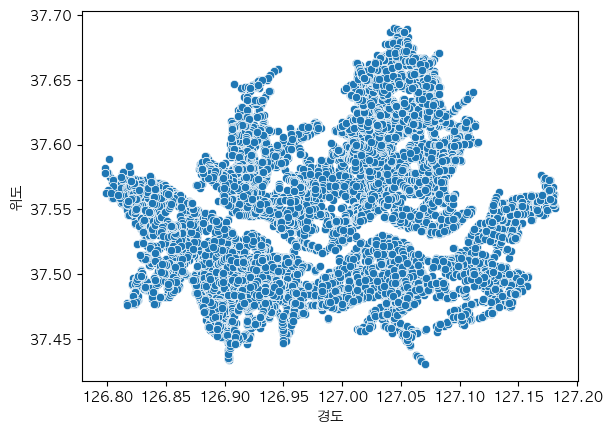

In [22]:
# 모든 정류소의 위치를 우선 그래프로 확인하기
sns.scatterplot(x='경도', y='위도', data=stop_info, palette='pastel')

In [23]:
# 평균 이동(Mean Shift) - 데이터의 밀도가 가장 높은 곳으로 중심 이동시키는 방식으로 군집화
# 중심에 소속된 데이터의 평균 거리를 중심으로 이동하는 k-means에 비해 데이터의 밀도가 높은 곳으로 이동하며 군집의 개수를 미리 정해주지 않아도 된다는 장점이 있음
features = stop_info[['위도', '경도']]
# 해당 알고리즘은 bandwith(대역폭) 속성이 큰 영향을 미치나 따로 지정을 안해줘도 최적화된 대역폭을 찾아 적용함
#   -> 실행 결과 1개의 클러스터만 생성되어 최적 대역폭을 확인 후 대역폭을 조정
print('최적 대역폭: ', estimate_bandwidth(features))

최적 대역폭:  0.08924156315793284


In [24]:
ms = MeanShift(bandwidth=0.03, cluster_all=False, n_jobs=1)
ms.fit(features) # 약 3분소요
cluster_center = ms.cluster_centers_
cluster_center = [tuple(c) for c in cluster_center]
print('centers: ', cluster_center)

centers:  [(37.61900201095397, 127.02915507070487), (37.49226473011265, 126.90706895845173), (37.55940810870664, 126.9399892653818), (37.571464400178876, 127.02479097835423), (37.59163981793584, 126.92350342860144), (37.60556209499773, 127.07883118564361), (37.53447181895248, 126.85350047100391), (37.49299644266299, 127.02321246393268), (37.487986748818244, 126.98551005875268), (37.511937943286334, 127.12590913390069), (37.54178690617169, 127.14044311345874), (37.49763374954913, 127.08867910442498)]


## ✅ 시각화

In [25]:
# # 승차인구가 가장 많은 정류소 상위 10개
# in_top10 = df_final.sort_values('월평균승차수', ascending=False).head(10)
# # 하차인구가 가장 많은 정류소 상위 10개
# out_top10 = df_final.sort_values('월평균하차수', ascending=False).head(10)
# # 승하차 합계 인구가 가장 많은 정류소 상위 10개
# total_top10 = df_final.sort_values('월평균승하차총계', ascending=False).head(10)

In [26]:
# sns.set_palette('pastel')

# sns.barplot(
#     data = in_top10,
#     x = '정류소명',
#     y = '월평균승차수'
# )
# plt.title('월평균승차수')
# plt.xticks(rotation=65, fontsize=9)
# plt.show()

# sns.barplot(
#     data = in_top10,
#     x = '정류소명',
#     y = '월평균하차수'
# )
# plt.title('월평균하차수')
# plt.xticks(rotation=65, fontsize=9)
# plt.show()

# sns.barplot(
#     data = in_top10,
#     x = '정류소명',
#     y = '월평균승하차총계'
# )
# plt.title('월평균승하차 총계')
# plt.xticks(rotation=65, fontsize=9)

# plt.show()

In [27]:
# Mean Shift 알고리즘 추천 위치 12곳 시각화
# 나중에 folium.plugin의 marker cluster를 이용해 주변 정류소 수를 표현할 수 있는지 알아보자
mymap = folium.Map(location=[37.541, 126.986], zoom_start=12)

i = 1 
for center in cluster_center:
    folium.Marker(center, tooltip=f'location{i}', icon=folium.Icon(color='lightred', icon='star')).add_to(mymap)
    i += 1
    
for neighbors in tqdm(neighbors_dict.values()):
    for neighbor in neighbors:
        folium.Circle(radius=10, location=[neighbor[0], neighbor[1]], color='#967BDC', fill=True).add_to(mymap)
mymap

100%|████████████████████████████████████| 10626/10626 [00:20<00:00, 522.93it/s]
